In [1]:
import numpy as np
import json
import random
import math
from time import time
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt

# TSP Analysis for Orange County Deliveries


## Setup and Data Loading

In [2]:
# Load Files
distance_matrix = np.load('distance_matrix.npy')
print(f"Distance matrix shape: {distance_matrix.shape}")

with open('locations_mapping.json', 'r') as f:
    locations_mapping = json.load(f)

print(f"Number of locations: {len(locations_mapping)}")
print("\nExample distance:", distance_matrix[0][1])
print("\nExample location data:", locations_mapping['0'])



Distance matrix shape: (201, 201)
Number of locations: 201

Example distance: 26649.0

Example location data: {'latitude': 33.6424, 'longitude': -117.8417, 'address': 'UCI Warehouse: 2006 McGaw Ave, Irvine, CA 92614'}


In [3]:
def calculate_route_distance(route, distance_matrix):
    """Calculate total distance of a route including return to warehouse"""
    total_distance = 0
    for i in range(len(route) - 1):
        total_distance += distance_matrix[route[i]][route[i + 1]]
    # Add distance back to warehouse (index 0)
    total_distance += distance_matrix[route[-1]][0]
    return total_distance

def plot_route(route, locations_mapping, distance_matrix, title="TSP Route"):
    """Plot the route on a scatter plot"""
    plt.figure(figsize=(12, 8))
    
    # Extract coordinates using longitude and latitude
    x_coords = [locations_mapping[str(i)]['longitude'] for i in route]
    y_coords = [locations_mapping[str(i)]['latitude'] for i in route]
    
    # Add warehouse return coordinates
    x_coords.append(locations_mapping['0']['longitude'])
    y_coords.append(locations_mapping['0']['latitude'])
    
    # Plot points and routes
    plt.scatter(x_coords, y_coords, c='blue', s=50)
    plt.plot(x_coords, y_coords, 'r-', alpha=0.5)
    
    # Highlight warehouse
    plt.scatter([x_coords[0]], [y_coords[0]], c='red', s=100, label='Warehouse')
    
    # Add title and total distance
    total_distance = calculate_route_distance(route, distance_matrix)
    plt.title(f"{title}\nTotal Distance: {total_distance:.2f}")
    
    plt.legend()
    plt.grid(True)
    plt.show()



Test route: [0, 4, 1, 2, 3]
Test route distance: 106818.0


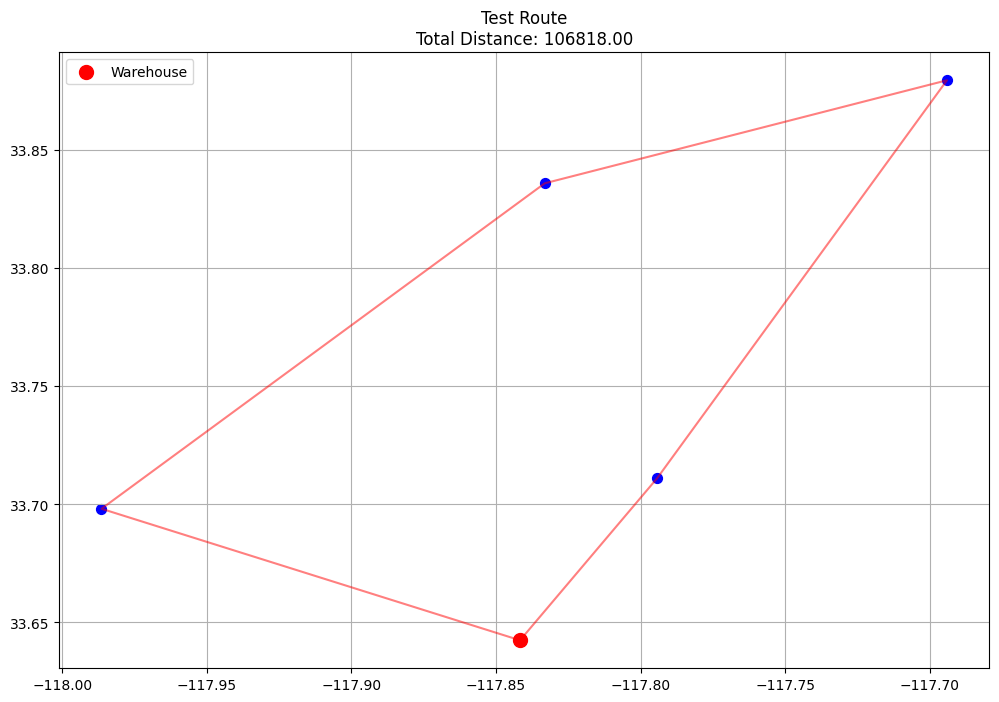

In [4]:
# Test the functions
test_route = [0] + random.sample(range(1, 5), 4)  # Small 5-location route
print("Test route:", test_route)
print("Test route distance:", calculate_route_distance(test_route, distance_matrix))
plot_route(test_route, locations_mapping, distance_matrix, "Test Route")

# Implement Algorithms

---

## Nearest Neighbor

In [5]:

def nearest_neighbor():
    """Implement Nearest Neighbor algorithm"""
    # TODO: Implement Nearest Neighbor algorithm
    # 1. Start from warehouse (index 0)
    # 2. Each time, find the nearest unvisited location
    # 3. Add it to the route
    # 4. Repeat until all locations are visited
    # 5. Return the route
    pass

In [6]:
#OK
def nearest_neighbor(address_dict):
    # Convert the dictionary to a DataFrame titled 'locations_mapping_df'
    locations_mapping_df = pd.DataFrame.from_dict(address_dict, orient='index').reset_index(drop=True)

    # Create 2 dataframes: remaining_node includes addresses without the starting point (UCI Warehouse); visited_address will append order of address visited starting from UCI Warehouse
    remaining_node = locations_mapping_df.iloc[1:].reset_index(drop=True)  # Exclude the first row
    visited_address = locations_mapping_df.iloc[:1].reset_index(drop=True)  # Include only the first row

    while not remaining_node.empty: 
        # Get the coordinates of the last visited location
        current_longitude_coordinate = visited_address.iloc[-1]['longitude']
        current_latitude_coordinate = visited_address.iloc[-1]['latitude']

        # Calculate distances to all remaining nodes
        remaining_node = remaining_node.assign(
            Distance=np.sqrt(
                (current_longitude_coordinate - remaining_node["longitude"]) ** 2 +
                (current_latitude_coordinate - remaining_node["latitude"]) ** 2
            )
        )

        # Find the next address (row with the minimum distance)
        next_address = remaining_node.loc[remaining_node["Distance"].idxmin()]

        # Append the next address to the visited_address dataframe
        visited_address = pd.concat(
            [visited_address, pd.DataFrame([next_address], columns=remaining_node.columns)],
            ignore_index=True
        )

        # Remove the visited node from remaining nodes
        remaining_node = remaining_node.drop(remaining_node["Distance"].idxmin()).reset_index(drop=True)

    # Return to the start location
    visited_address = pd.concat([visited_address, locations_mapping_df.iloc[:1]], ignore_index=True)
    visited_address['number'] = visited_address['address'].map(locations_mapping_df.reset_index().set_index('address')['index'])

    # Calculate total distance 
    total_distance = calculate_route_distance(visited_address.loc[:,'number'].to_list(), distance_matrix) 

    return total_distance

In [7]:
# Testing nearest neighbor
try:
    start_time = time()
    nn_route = nearest_neighbor()
    end_time = time()
    
    print("\nNearest Neighbor Results:")
    print(f"Time taken: {end_time - start_time:.2f} seconds")
    print(f"Route length: {len(nn_route)}")
    print(f"Total distance: {calculate_route_distance(nn_route):.2f}")
    
    plot_route(nn_route, "Nearest Neighbor Route")
except:
    print("Error: Nearest Neighbor algorithm not implemented yet")


Error: Nearest Neighbor algorithm not implemented yet


## Simulated Annealing

In [8]:
def simulated_annealing(distance_matrix, initial_temp=100.0, cooling_rate=0.995, iterations=100000):
    """Implement Simulated Annealing algorithm"""
    start_time = time()
    n_cities = len(distance_matrix)
    
    # Generate initial solution
    current_route = [0] + random.sample(range(1, n_cities), n_cities-1)
    current_distance = calculate_route_distance(current_route, distance_matrix)
    
    best_route = current_route.copy()
    best_distance = current_distance
    
    temperature = initial_temp
    
    # Main loop
    for _ in range(iterations):
        # Generate neighbor by swapping two random cities (excluding warehouse)
        new_route = current_route.copy()
        idx1, idx2 = random.sample(range(1, len(new_route)), 2)
        new_route[idx1], new_route[idx2] = new_route[idx2], new_route[idx1]
        
        new_distance = calculate_route_distance(new_route, distance_matrix)
        
        # Accept if better, or with probability if worse
        if new_distance < current_distance:
            current_route = new_route
            current_distance = new_distance
            if new_distance < best_distance:
                best_route = new_route.copy()
                best_distance = new_distance
        else:
            if random.random() < np.exp(-(new_distance - current_distance) / temperature):
                current_route = new_route
                current_distance = new_distance
        
        temperature *= cooling_rate
    
    computation_time = time() - start_time
    return best_route, computation_time


Simulated Annealing Results:
Time taken: 4.86 seconds
Route length: 201
Total distance: 1544.89 km


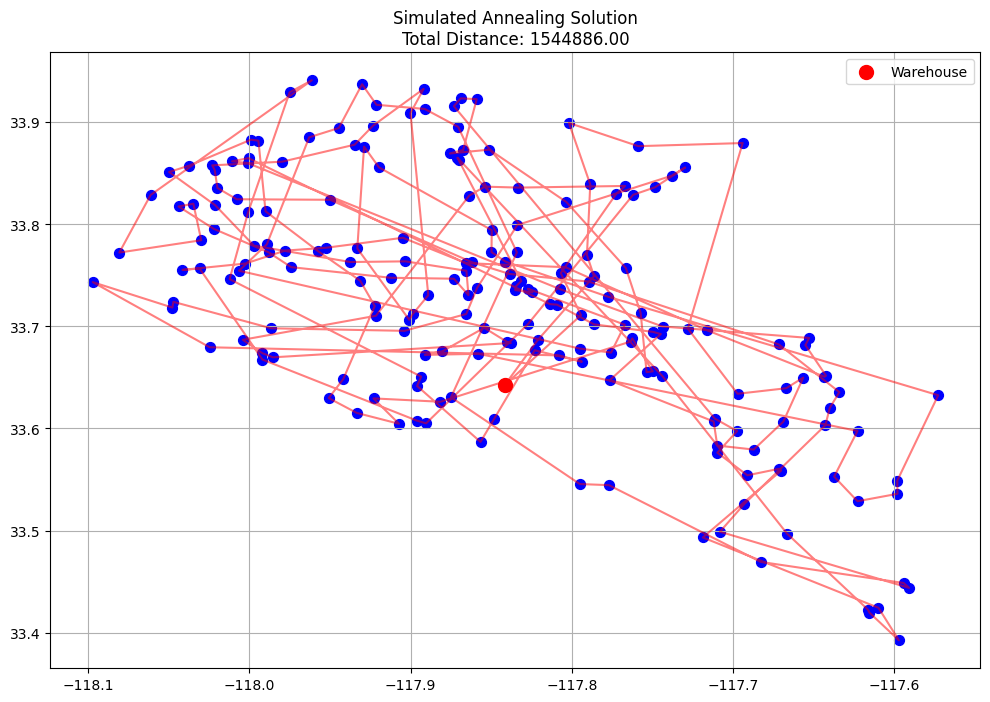

In [9]:
sa_route, sa_time = simulated_annealing(distance_matrix, 
                                       initial_temp=1000.0,  # Higher initial temperature
                                       cooling_rate=0.999,   # Slower cooling
                                       iterations=200000)    # More iterations

print("\nSimulated Annealing Results:")
print(f"Time taken: {sa_time:.2f} seconds")
print(f"Route length: {len(sa_route)}")
sa_distance = calculate_route_distance(sa_route, distance_matrix)
print(f"Total distance: {sa_distance/1000:.2f} km")

# Plot SA route
plot_route(sa_route, locations_mapping, distance_matrix, "Simulated Annealing Solution")


In [10]:
# import geopy.distance

# coords_1 = (52.2296756, 21.0122287)
# coords_2 = (52.406374, 16.9251681)

# print(geopy.distance.geodesic(coords_1, coords_2).km)

## Random Search (Base case)

In [11]:
# Change it to 10000 later
def random_search(n_samples=10000):
    """Implement Random Search algorithm"""
    best_route = None
    best_distance = float('inf')  # Initialize with infinity
    
    # Get number of locations (excluding warehouse)
    n_locations = len(distance_matrix)
    
    for _ in range(n_samples):
        # Generate random route (keeping warehouse as start)
        current_route = [0] + random.sample(range(1, n_locations), n_locations-1)
        
        # Calculate total distance
        current_distance = calculate_route_distance(current_route, distance_matrix)
        
        # Update best route if current route is better
        # Take the average?
        if current_distance < best_distance:
            best_distance = current_distance
            best_route = current_route
    
    return best_route




Random Search Results:
Time taken: {end_time - start_time:.2f} seconds
Route length: 201
Total distance: 4979977.00


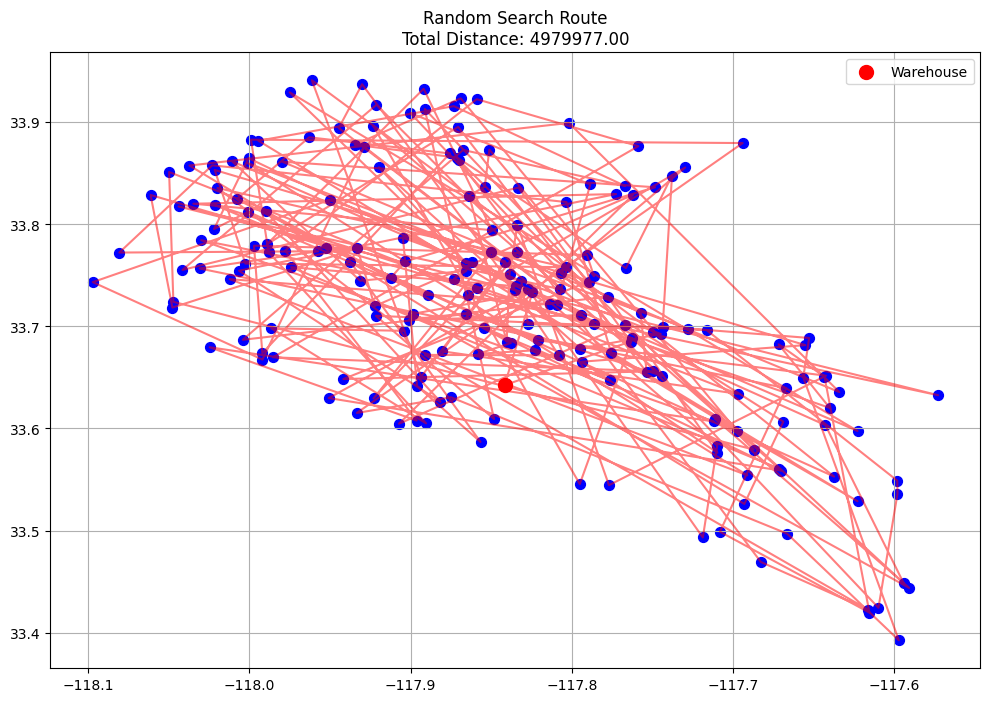

In [12]:
# Test Random Search
try:
    start_time = time()
    random_route = random_search()
    end_time = time()
    random_time = "{end_time - start_time:.2f}"
    random_distance = calculate_route_distance(random_route, distance_matrix)
    
    print("\nRandom Search Results:")
    print("Time taken: " + random_time + " seconds")
    print(f"Route length: {len(random_route)}")
    print(f"Total distance: {random_distance:.2f}")
    
    plot_route(random_route, locations_mapping, distance_matrix, "Random Search Route")
except Exception as e:
    print(f"Error in Random Search: {str(e)}")

### Maybe add solution case for google map tsp solution api as a metric?

---


# METRIC SESSION

# Call and Draw solution google map



OR-Tools solution loaded from: 2024-11-26 00:04:06


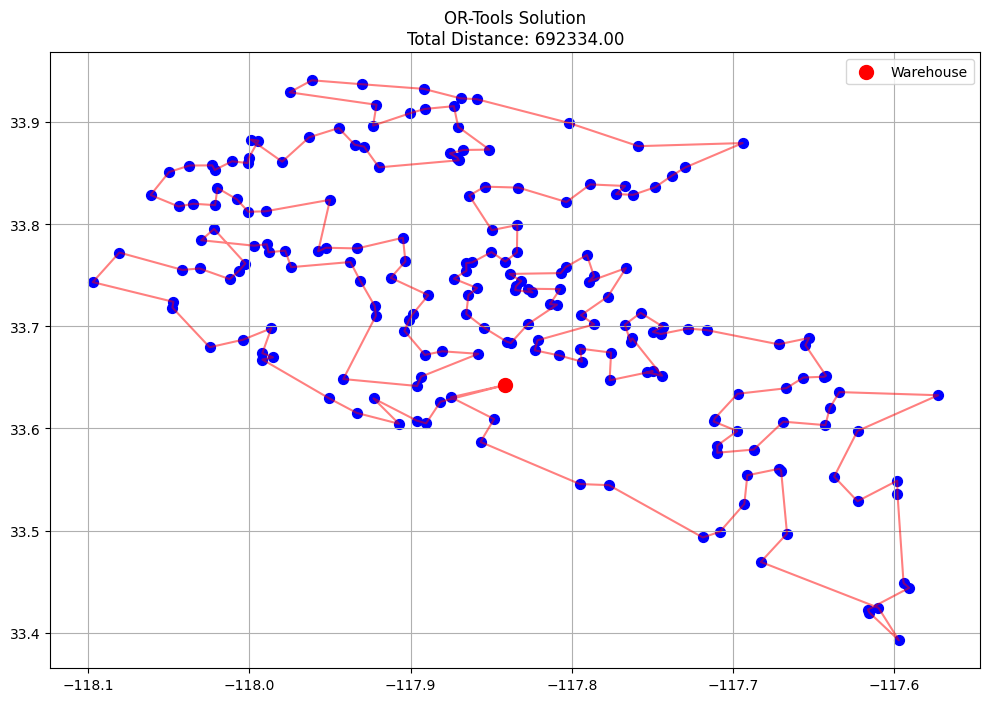

In [13]:
# Load OR-Tools solution
with open('ortools_solution.json', 'r') as f:
    ortools_data = json.load(f)
print("\nOR-Tools solution loaded from:", ortools_data['timestamp'])

# Plot OR-Tools solution
ortools_route = ortools_data['route']
ortools_distance = calculate_route_distance(ortools_route, distance_matrix)
plot_route(ortools_route, locations_mapping, distance_matrix, "OR-Tools Solution")


In [14]:

# Create comparison table
results = [
    {
        'Algorithm': 'Simulated Annealing',
        'Distance (km)': sa_distance/1000,
        'Time (s)': sa_time,
        'Gap to OR-Tools (%)': ((sa_distance - ortools_distance)/ortools_distance * 100)
    },
    {
        'Algorithm': 'Random Search',
        'Distance (km)': random_distance/1000,
        'Time (s)': random_time,
        'Gap to OR-Tools (%)': ((random_distance - ortools_distance)/ortools_distance * 100)
    },
    {
        'Algorithm': 'OR-Tools',
        'Distance (km)': ortools_distance/1000,
        'Time (s)': ortools_data.get('timestamp'),
        'Gap to OR-Tools (%)': 0.0
    }
]



In [15]:
results

[{'Algorithm': 'Simulated Annealing',
  'Distance (km)': 1544.886,
  'Time (s)': 4.860507965087891,
  'Gap to OR-Tools (%)': 123.14172061461663},
 {'Algorithm': 'Random Search',
  'Distance (km)': 4979.977,
  'Time (s)': '{end_time - start_time:.2f}',
  'Gap to OR-Tools (%)': 619.3026776093619},
 {'Algorithm': 'OR-Tools',
  'Distance (km)': 692.334,
  'Time (s)': '2024-11-26 00:04:06',
  'Gap to OR-Tools (%)': 0.0}]